In [2]:
import healpy as hp
import numpy as np
import matplotlib as mpl
import matplotlib.image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib import lines
from matplotlib.image import NonUniformImage
import astropy.io
from astropy.io import fits
from astropy import units as u
from astropy.units import cds
from astropy import constants as const
import random
import scipy
from scipy import stats

In [2]:
# plots peak frequency mean
#v = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4)
#hp.mollview(p, unit = 'GHz', title = 'Primary peak frequency posterior mean', min=17, max = 23, cmap = 'inferno')

# plots mean amplitude @ 22.8 GHz
#m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1) #reads mean amplitude map
#m_K = ((2*(v**2)*(1.381e-23)*m)/((3e+8)**2))*u.J/((u.m)**2*u.sr) # sets units
#m_J = (m_K).to(cds.MJy/cds.sr) #converts to MJy/sr
#I = m_J * cds.sr/cds.MJy
#hp.mollview(m_J, unit='MJy sr^-1 @ 22.8 GHz', title = 'Primary amplitude posterior mean', min=1e-16, max=3e-14, norm='log', cmap = 'pink')

#idx = np.random.choice(np.arange(len(v)), 500000, replace=False) #randomly selects 1000 values from 1 to n, where n is number of possible values in v
#v_c = v[idx] #makes an array of the entries of p corresponding to these values
#I_c = I[idx] #does the same for I

#a = plt.scatter(v_c, I_c)
#plt.ylim(8e-18, 3e-13)
#plt.xlim(9, 31)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlabel('Frequency (GHz)')
#plt.ylabel('Specific Intensity (MJy/sr)')

In [12]:
def I(A1, A2, nu_p1, nu_sd, f, nu):
    nu_p0 = 30. 
    nu_p2 = 33.35 #sets frequency peak for all secondary pixels
    nu_01 = 22.8 #sets reference freq for primary pixels
    nu_02 = 41.0 #sets reference freq for secondary pixels
    nu_1 = nu_01*(nu_p0/nu_p1) #sets the value nu1 for f_sd1
    nu_2 = nu_02*(nu_p0/nu_p2) #same for 2
    nu_fsd1 = nu*(nu_p0/nu_p1)
    nu_fsd2 = nu*(nu_p0/nu_p2)
    
    f_sd1 = np.interp(nu_1, nu_sd, f) #interpolates nu_sd and f to create f_sd1 at nu1
    f_sd2 = np.interp(nu_2, nu_sd, f) #same for 2
    f_nu1 = np.interp(nu_fsd1, nu_sd, f) #same for general nu
    f_nu2 = np.interp(nu_fsd2, nu_sd, f) #same for general nu
    
    I_1 = A1*((nu_01/nu)**2)*(f_nu1/f_sd1) #component from primary 
    I_2 = A2*((nu_02/nu)**2)*(f_nu2/f_sd2) #component from secondary
    m_K1 = I_1*u.K*(2*(nu_p1*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #adds units to primary
    m_K2 = I_2*u.K*(2*(nu_p2*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #same for secondary
    m_J1 = m_K1.to(cds.MJy/cds.sr)
    m_J2 = m_K2.to(cds.MJy/cds.sr)
    m_J = m_J1 + m_J2
    return m_J * cds.sr/cds.MJy #gets rid of units for plotting purposes

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
b
A1: 219.3749237060547
A2: 59.24541091918945
nu_p1: 17.847368240356445
r
A1: 22.441509246826172
A2: 6.931092739105225
nu_p1: 19.090917587280273
g
A1: 12.222434997558594
A2: 1.1840295791625977
nu_p1: 17.82005500793457


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

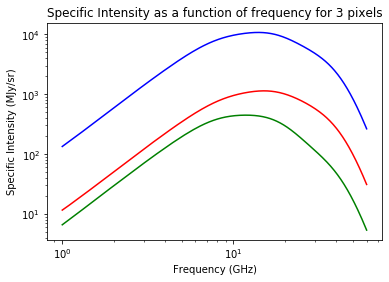

In [4]:
# This cell uses the I() function defined above to plot
# I_nu vs nu for a number, b, of pixels. It also prints 
# the primary and secondary amplitudes and primary peak
# frequency for each pixel.

m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1) #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak frequency primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2) #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")
data = hdu[3].data
nu_sd = np.array([i[0] for i in data])
f = np.array([i[1] for i in data])

b = 3 #number of pixels to be plotted
nu = np.linspace(1, 60, len(m)) #creates a range of values nu
pix = np.random.choice(range(len(m)), b) #randomly selects a pixel

for i in range(b):
    a1_i = m[pix[i]] #sets A1 for the ith random pixel
    a2_i = n[pix[i]] #sets A2 for the ith random pixel
    nup1_i = nu_p[pix[i]] #sets nu_p1 for the ith random pixel
    
    I_nui = I(a1_i, a2_i, nup1_i, nu_sd, f, nu) #sets I_nu(nu) for the ith random pixel
    
    color = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] #creates an array of four different color possibilities
    plt.plot(nu, I_nui, color[i]) #plots I_nu(nu) for each pixel, each in a different color
    
    print(color[i])
    print('A1: ' + str(a1_i))
    print('A2: ' + str(a2_i))
    print('nu_p1: ' + str(nup1_i))

plt.yscale('log')
plt.xscale('log')
plt.title('Specific Intensity as a function of frequency for ' + str(b) + ' pixels')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

Text(0, 0.5, 'Template Frequency')

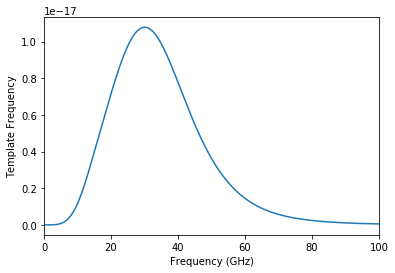

In [5]:
#This cell plots a curve of template frequency vs. frequency

hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")
data = hdu[3].data
p = np.array([i[0] for i in data])
f = np.array([i[1] for i in data])

plt.plot(p,f)
plt.xlabel('Frequency (GHz)')
plt.xlim(0,100)
plt.ylabel('Template Frequency')

In [6]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


Pixel 0
354663 b
f_CNM: 6.326647778041661
A1: 763.1305541992188
A2: 147.29925537109375
nu_p1: 18.84634017944336
Pixel 1
374460 r
f_CNM: -1.6374999999999998e+32
A1: 988.575927734375
A2: 160.085205078125
nu_p1: 19.348339080810547
Pixel 2
387186 g
f_CNM: -1.6374999999999998e+32
A1: 788.067626953125
A2: 162.25369262695312
nu_p1: 18.96971893310547
Pixel 3
359002 c
f_CNM: -1.6374999999999998e+32
A1: 869.3137817382812
A2: 197.83941650390625
nu_p1: 19.68379020690918


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

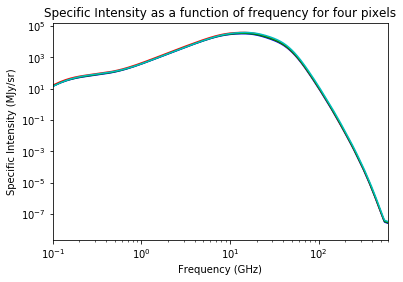

In [7]:
# This cell plots four random pixels and prints
# their f_CNM values in an attempt to see if there 
# is any relation between the two.

m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1) #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2) #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")
data = hdu[3].data #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])
f = np.array([i[1] for i in data])

CNM = hp.read_map('fcnm_hi4pi_hpx.fits') #reads map of CNM fraction
mask_ones = np.ones_like(CNM) #creates an array of 1s the size and shape of CNM
mask_zeros = np.where(CNM < 0, 0, mask_ones) #sets mask_one values to 0 where the f_CNM is unreasonable
mask_map = hp.pixelfunc.ud_grade(mask_zeros, 256) #degrades mask array to the right NSIDE
mask = np.where(mask_map < 1, 0, mask_map) #sets mask values to 0 where mask value is not 1
CNM_dgrade = hp.pixelfunc.ud_grade(CNM, 256) #degrades CNM map to right NSIDE
f_CNM = CNM_dgrade[mask == 1]

m = m[mask == 1]
nu_p = nu_p[mask == 1]
n = n[mask == 1]

pix = []
for i in range(4):
    x = random.randint(330000, 400000)
    pix.append(x)

b = len(pix) #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(m)) #creates a range of values nu

for i in range(b):
    a1_i = m[pix[i]] #sets A1 for the ith random pixel
    a2_i = n[pix[i]] #sets A2 for the ith random pixel
    nup1_i = nu_p[pix[i]] #sets nu_p1 for the ith random pixel
    I_nui = I(a1_i, a2_i, nup1_i, nu_sd, f, nu) #sets I_nu(nu) for the ith random pixel
    color = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] #creates an array of four different color possibilities
    print('Pixel ' + str(i))
    print(pix[i], color[i])
    #if f_CNM[pix[i]] >= 0: #sets it to only show up on the plot if the f_CNM is high enough
    plt.plot(nu, I_nui, color[i]) #plots I_nu(nu) for each pixel, each in a different color
    print('f_CNM: ' + str(f_CNM[pix[i]]*100))
    print('A1: ' + str(a1_i))
    print('A2: ' + str(a2_i))
    print('nu_p1: ' + str(nup1_i))
    #else: print('f_CNM is tiny')

plt.yscale('log')
plt.xscale('log')
plt.xlim(.1,600)
plt.title('Specific Intensity as a function of frequency for four pixels')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

(0, 40)

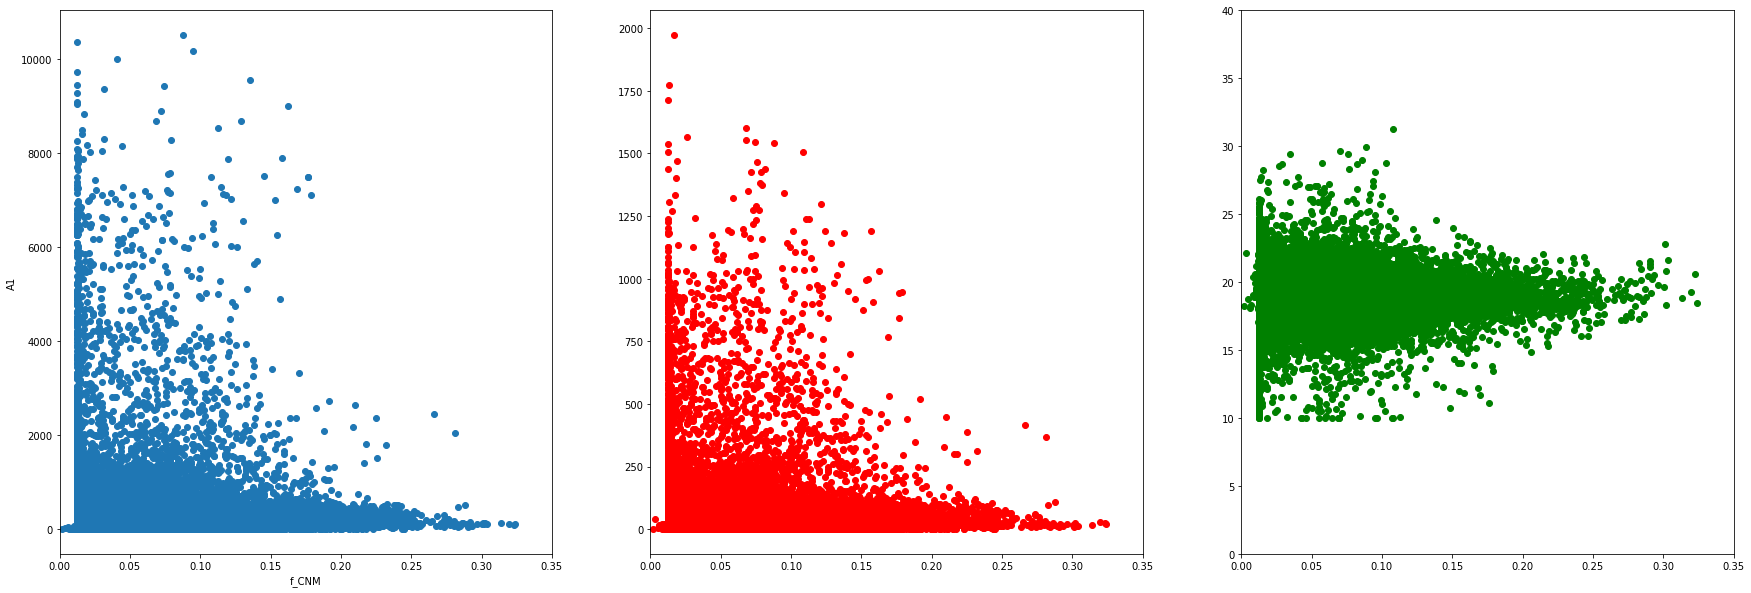

In [8]:
# Looks for trends in the primary and secondary amplitude vs. f_CNM (blue and red)
# and in peak frequency vs. f_CNM (green)

idx = np.random.choice(np.arange(len(m)), 100000, replace=False)
a1 = m[idx]
a2 = n[idx]
nup1 = nu_p[idx]
fCNM = f_CNM[idx]

fig, ax = plt.subplots(1,3, figsize=(30,10))

for i in range(3):
    ax[i].set_xlim(0, .35)

ax[0].scatter(fCNM, a1)
ax[0].set_xlabel("f_CNM")
ax[0].set_ylabel("A1")
plt.ylim(0, 12000)
ax[1].scatter(fCNM, a2, c='r')
plt.ylim(0, 2500)
ax[2].scatter(fCNM, nup1, c='g')
plt.ylim(0, 40)
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(-1, 2000)

4.476234425473004
0.6081770383740093
38.492063492063494
7.836401113803204


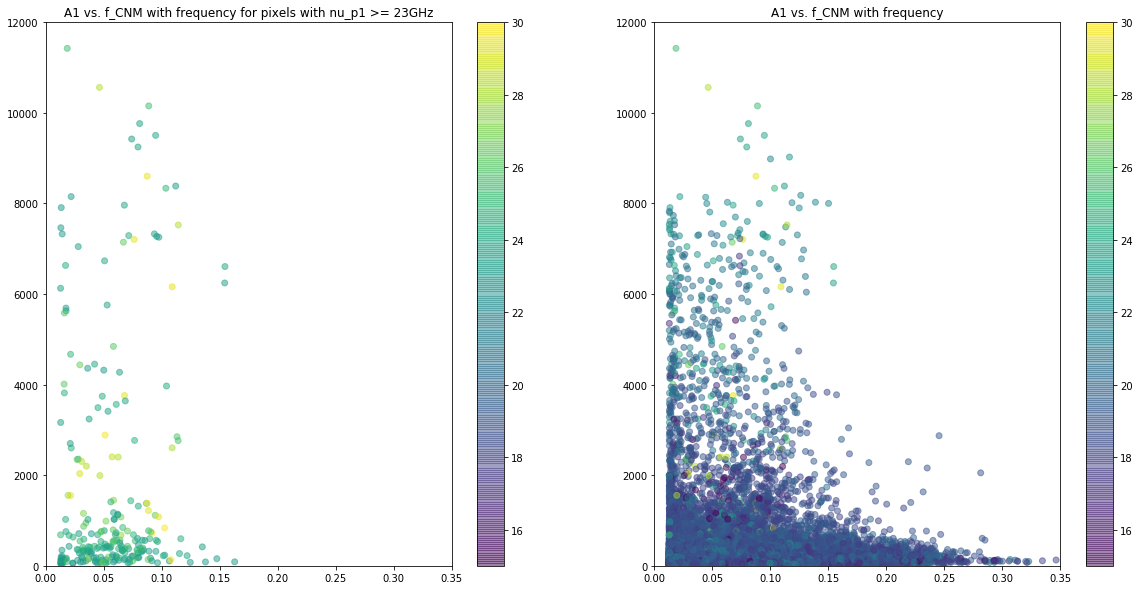

In [9]:
def finite_fCNM(i,t):
    '''Input:
        i: map
        t: array of sample pixels
        
       Return:
        Array of the sample pixels of the map for which f_CNM is both finite and above .0128'''
    
    l = []
    for a in t:
        if np.isfinite(f_CNM[a]) == 1 and f_CNM[a] > 0.0128:
            l.append(i[a])
    return np.array(l)

t = np.random.choice(np.arange(len(f_CNM)), 100000, replace=False)

a1 = finite_fCNM(m,t)
a2 = finite_fCNM(n,t)
nup1 = finite_fCNM(nu_p,t)
fCNM = finite_fCNM(f_CNM,t)

lim = 23

a1_hi = []
fCNM_hi = []
nup1_hi = []
for x in range(len(fCNM)):
    if nup1[x] >= lim:
        a1_hi.append(a1[x])
        fCNM_hi.append(fCNM[x])
        nup1_hi.append(nup1[x])

hia_hinup = sum(1 if a1[i] >= 750 and nup1[i] >= lim else 0 for i in range(len(a1)))#number of points at high a1 with nup1 above limit
loa_hinup = sum(1 if a1[i] < 750 and nup1[i] >= lim else 0 for i in range(len(a1))) #number of points at low a1 with nup1 above limit
hia = sum(1 if a1[i] >= 750 else 0 for i in range(len(a1)))
loa = sum(1 if a1[i] < 750 else 0 for i in range(len(a1)))

fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots points of nu_p1 greater than a certain limit
a = ax[0].scatter(fCNM_hi, a1_hi, alpha=.5, c=nup1_hi, vmin=15, vmax=30)
ax[0].set_ylim(0,12000)
ax[0].set_xlim(0,.35)
ax[0].set_title('A1 vs. f_CNM with frequency for pixels with nu_p1 >= ' + str(lim) + 'GHz')
fig.colorbar(a, ax=ax[0])

#plots all 100000 points
b = ax[1].scatter(fCNM, a1, alpha=.5, c=nup1, vmin=15, vmax=30)
ax[1].set_ylim(0,12000)
ax[1].set_xlim(0,.35)
ax[1].set_title('A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])

print(100*hia_hinup/hia) #Percent of high A1 vals with hi nup1: 
print(100*loa_hinup/loa) #Percent of low A1 vals with hi nup1:
print(100*hia_hinup/(hia_hinup+loa_hinup)) #Percent of hi nup1 pixels with hi A1:
print(100*hia/(hia+loa)) #Percent of pixels with hi A1:

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


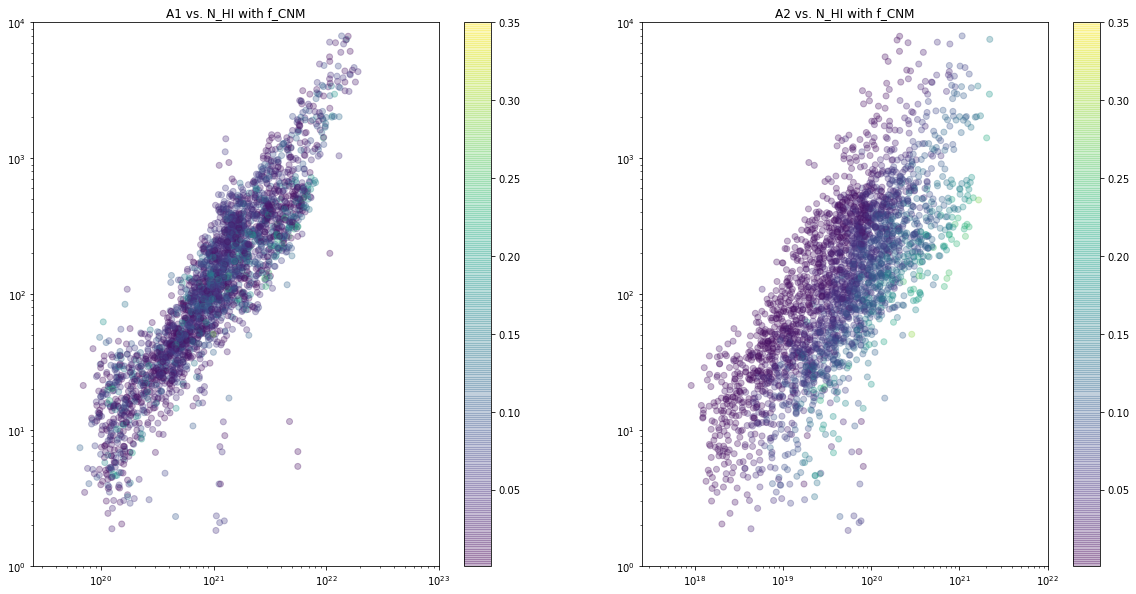

In [16]:
t = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False)

a1 = finite_fCNM(m,t)
a2 = finite_fCNM(n,t)
nup1 = finite_fCNM(nu_p,t)
fCNM = finite_fCNM(f_CNM,t)
h = hp.read_map('mom0_-90_90_1024.hpx.fits')
nh = hp.pixelfunc.ud_grade(h, 256)
N_HI = finite_fCNM(nh,t)
N_CNM = fCNM * N_HI

lim = 23

a1_hi = []
nCNM_hi = []
nup1_hi = []
for i in range(len(a1)):
    if nup1[i] >= lim:
        a1_hi.append(a1[i])
        nCNM_hi.append(N_CNM[i])
        nup1_hi.append(nup1[i])

hia_hinup = sum(1 if a1[i] >= 750 and nup1[i] >= lim else 0 for i in range(len(a1)))#number of points at high a1 with nup1 above limit
loa_hinup = sum(1 if a1[i] < 750 and nup1[i] >= lim else 0 for i in range(len(a1))) #number of points at low a1 with nup1 above limit
hia = sum(1 if a1[i] >= 750 else 0 for i in range(len(a1)))
loa = sum(1 if a1[i] < 750 else 0 for i in range(len(a1)))

fig, ax = plt.subplots(1,2, figsize=(20,10))


#plots points of nu_p1 greater than a certain limit
#a = ax[0].scatter(nCNM_hi, a1_hi, s=15, alpha=.5, c=nup1_hi, vmin=lim, vmax=26)
#ax[0].set_ylim(0,12000)
#ax[0].set_xlim(1e17,1e22)
#ax[0].set_ylim(1, 1e4)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_title('A1 vs. N_CNM with frequency for pixels with nu_p1 >= ' + str(lim) + 'GHz')
#fig.colorbar(a, ax=ax[0])

#plots all 100000 points
b = ax[0].scatter(N_HI, a1, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
#ax[0].set_ylim(0,12000)
ax[0].set_xlim(2.5e19, 1e23)
ax[0].set_ylim(1, 1e4)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('A1 vs. N_HI with f_CNM')
fig.colorbar(b, ax=ax[0])

c = ax[1].scatter(N_CNM, a1, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
#ax[1].set_ylim(0,12000)
ax[1].set_xlim(2.5e17, 1e22)
ax[1].set_ylim(1, 1e4)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('A2 vs. N_HI with f_CNM')
fig.colorbar(c, ax=ax[1])

"\n#plots all 100000 points\nc = ax[1,1].scatter(fCNM_hi, fa1_hi, alpha=.5, c=nup1_hi, vmin=lim, vmax=25)\nax[1,1].set_ylim(.5, 1)\nax[1,1].set_xlim(0,.35)\nax[1,1].set_title('f_A1 vs. f_CNM for high nu_p1')\nfig.colorbar(c, ax=ax[1,1])\n\nd = ax[1,2].scatter(fCNM_lo, fa1_lo, alpha=.5, c=nup1_lo, vmin=16, vmax=lim, cmap='viridis_r')\nax[1,2].set_ylim(.5, 1)\nax[1,2].set_xlim(0,.35)\nax[1,2].set_title('f_A1 vs. f_CNM for low nu_p1')\nfig.colorbar(d, ax=ax[1,2])"

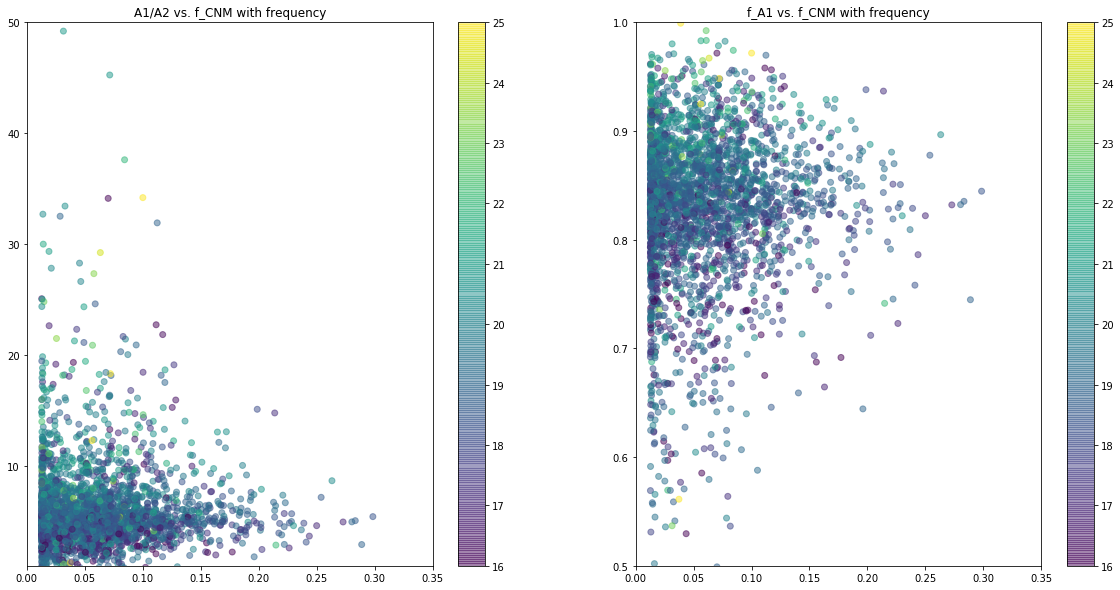

In [11]:
t = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False)

a1 = finite_fCNM(m,t)
a2 = finite_fCNM(n,t)
nup1 = finite_fCNM(nu_p,t)
fCNM = finite_fCNM(f_CNM,t)
r = a1/a2
fa1 = a1/(a1+a2)
fa2 = a2/(a1+a2)

lim = 19
'''
fa1_hi = []
fa1_lo = []
fCNM_hi = []
fCNM_lo = []
nup1_hi = []
nup1_lo = []
for i in range(len(a1)):
    if nup1[i] >= lim:
        fa1_hi.append(fa1[i])
        fCNM_hi.append(fCNM[i])
        nup1_hi.append(nup1[i])
    else:
        fa1_lo.append(fa1[i])
        fCNM_lo.append(fCNM[i])
        nup1_lo.append(nup1[i])
'''
fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots points of nu_p1 greater than a certain limit
a = ax[0].scatter(fCNM, r, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[0].set_ylim(1,50)
ax[0].set_xlim(0, .35)
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_title('A1/A2 vs. f_CNM with frequency')
fig.colorbar(a, ax=ax[0])

#plots points of nu_p1 greater than a certain limit
b = ax[1].scatter(fCNM, fa1, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[1].set_ylim(.5,1)
ax[1].set_xlim(0,.35)
#ax[1].set_xscale('log')
ax[1].set_title('f_A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])
'''
#plots all 100000 points
c = ax[1,1].scatter(fCNM_hi, fa1_hi, alpha=.5, c=nup1_hi, vmin=lim, vmax=25)
ax[1,1].set_ylim(.5, 1)
ax[1,1].set_xlim(0,.35)
ax[1,1].set_title('f_A1 vs. f_CNM for high nu_p1')
fig.colorbar(c, ax=ax[1,1])

d = ax[1,2].scatter(fCNM_lo, fa1_lo, alpha=.5, c=nup1_lo, vmin=16, vmax=lim, cmap='viridis_r')
ax[1,2].set_ylim(.5, 1)
ax[1,2].set_xlim(0,.35)
ax[1,2].set_title('f_A1 vs. f_CNM for low nu_p1')
fig.colorbar(d, ax=ax[1,2])'''

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


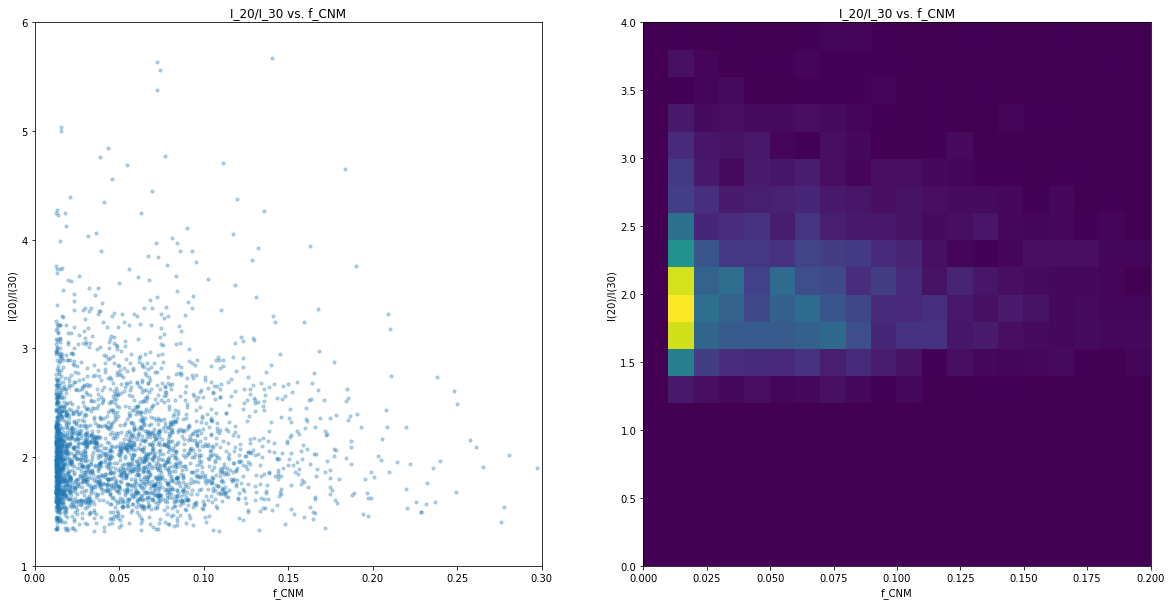

In [80]:
#ratio of I(20 GHz)/I(30 GHz) for various pixels plotted against f_CNM

m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1) #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2) #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")
data = hdu[3].data #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])
f = np.array([i[1] for i in data])
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')
f_CNM = hp.ud_grade(CNM, 256)

idx = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False)

a1 = finite_fCNM(m,idx)
a2 = finite_fCNM(n,idx)
nup1 = finite_fCNM(nu_p,idx)
fCNM = finite_fCNM(f_CNM,idx)

b = len(a1) #number of pixels to be plotted

I_20 = []
I_30 = []
for i in range(b):
    a1_i = m[i]
    a2_i = n[i] 
    nup1_i = nu_p[i] 
    I_20.append(I(a1_i, a2_i, nup1_i, nu_sd, f, 20))
    I_30.append(I(a1_i, a2_i, nup1_i, nu_sd, f, 30))

I20 = np.array(I_20)
I30 = np.array(I_30)
y = I20/I30

fig, ax = plt.subplots(1,2, figsize=(20,10))

a = ax[0].scatter(fCNM, y, s=10, alpha=.3)
ax[0].set_ylim(1,6)
ax[0].set_xlim(0, .3)
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')

b = ax[1].hist2d(fCNM, y, bins=20, range=[[0, .2], [0, 4]])

for i in range(2):
    ax[i].set_title('I_20/I_30 vs. f_CNM')
    ax[i].set_xlabel('f_CNM')
    ax[i].set_ylabel('I(20)/I(30)')

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


34
34
34
[12, 22]
f_CNM: 29.212861508131027
f_CNM: 1.2700235471129417
f_CNM: 30.164648592472076
f_CNM: 1.2700235471129417


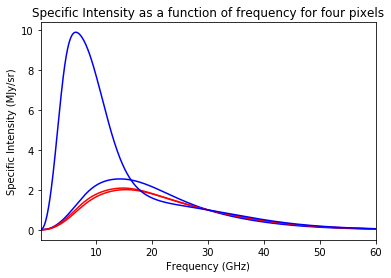

In [13]:
#Compares specific intensity curves for random points with low f_CNM to random points with high f_CNM

m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1) #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2) #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")
data = hdu[3].data #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])
f = np.array([i[1] for i in data])
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')
f_CNM = hp.ud_grade(CNM, 256)

idx = np.random.choice(np.arange(len(f_CNM)), 300000, replace=False)

m_hi = []
n_hi = []
nu_p_hi = []
f_CNM_hi = []
m_lo = []
n_lo = []
nu_p_lo = []
f_CNM_lo = []

for i in idx:
    if 0 < f_CNM[i] < 0.02:
        m_lo.append(m[i])
        n_lo.append(n[i])
        nu_p_lo.append(nu_p[i])
        f_CNM_lo.append(f_CNM[i])
    elif 0.29 < f_CNM[i] < 0.31:
        m_hi.append(m[i])
        n_hi.append(n[i])
        nu_p_hi.append(nu_p[i])
        f_CNM_hi.append(f_CNM[i])

print(len(m_hi))
print(len(n_hi))
print(len(f_CNM_hi))

pix_lo = []
pix_hi = []
for i in range(2):
    x = random.randint(0, len(m_lo))
    pix_lo.append(x-1)
    y = random.randint(0, len(m_hi))
    pix_hi.append(y-1)
print(pix_hi)
    
b = len(pix_lo) #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(m_lo)) #creates a range of values nu

for i in range(b):
    a1_lo = m_lo[pix_lo[i]] 
    a2_lo = n_lo[pix_lo[i]] 
    nup1_lo = nu_p_lo[pix_lo[i]] 
    I_nulo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, nu) 
    I_30lo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, 30)
    
    a1_hi = m_hi[pix_hi[i]] 
    a2_hi = n_hi[pix_hi[i]] 
    nup1_hi = nu_p_hi[pix_hi[i]]
    I_nuhi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, nu)
    I_30hi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, 30)
    
    plt.plot(nu, I_nuhi/I_30hi, 'r')
    plt.plot(nu, I_nulo/I_30lo, 'b')
    
    #print('Pixel ' + str(i))
    #print(pix[i], color[i])
    print('f_CNM: ' + str(f_CNM_hi[pix_hi[i]]*100))
    print('f_CNM: ' + str(f_CNM_lo[pix_lo[i]]*100))
    #print('A1: ' + str(a1_i))
    #print('A2: ' + str(a2_i))
    #print('nu_p1: ' + str(nup1_i))
                              
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlim(.1,60)
    plt.title('Specific Intensity as a function of frequency for four pixels')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Specific Intensity (MJy/sr)')

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

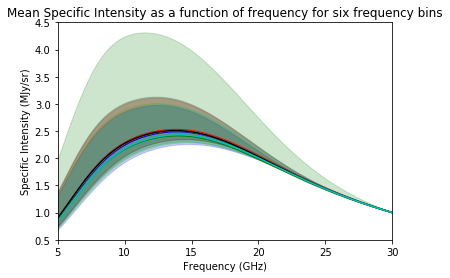

In [52]:
m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1) #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2) #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")
data = hdu[3].data #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])
f = np.array([i[1] for i in data])
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')
f_CNM = hp.ud_grade(CNM, 256)

idx = np.random.choice(np.arange(len(f_CNM)), len(f_CNM), replace=False)

m_0, m_1, m_2, m_3, m_4, m_5 = ([] for i in range(6))
n_0, n_1, n_2, n_3, n_4, n_5 = ([] for i in range(6))
nu_p0, nu_p1, nu_p2, nu_p3, nu_p4, nu_p5 = ([] for i in range(6))
f_CNM0, f_CNM1, f_CNM2, f_CNM3, f_CNM4, f_CNM5 = ([] for i in range(6))

for x in idx: #sorts the pixels into bins based on fCNM
    if 0 < f_CNM[x] <= 0.05:
        m_0.append(m[x])
        n_0.append(n[x])
        nu_p0.append(nu_p[x])
    elif 0.05 < f_CNM[x] <= 0.10:
        m_1.append(m[x])
        n_1.append(n[x])
        nu_p1.append(nu_p[x])
    elif 0.10 < f_CNM[x] <= 0.15:
        m_2.append(m[x])
        n_2.append(n[x])
        nu_p2.append(nu_p[x])
    elif 0.15 < f_CNM[x] <= 0.20:
        m_3.append(m[x])
        n_3.append(n[x])
        nu_p3.append(nu_p[x])
    elif 0.20 < f_CNM[x] <= 0.25:
        m_4.append(m[x])
        n_4.append(n[x])
        nu_p4.append(nu_p[x])
    elif 0.25 < f_CNM[x] <= 0.30:
        m_5.append(m[x])
        n_5.append(n[x])
        nu_p5.append(nu_p[x])

m_m = [np.mean(m_0), np.mean(m_1), np.mean(m_2), np.mean(m_3), np.mean(m_4), np.mean(m_5)]
n_m = [np.mean(n_0), np.mean(n_1), np.mean(n_2), np.mean(n_3), np.mean(n_4), np.mean(n_5)]
nu_pm = [np.mean(nu_p0), np.mean(nu_p1), np.mean(nu_p2), np.mean(nu_p3), np.mean(nu_p4), np.mean(nu_p5)]

m_std = [np.std(m_0), np.std(m_1), np.std(m_2), np.std(m_3), np.std(m_4), np.std(m_5)]
n_std = [np.std(n_0), np.std(n_1), np.std(n_2), np.std(n_3), np.std(n_4), np.std(n_5)]
nu_pstd = [np.std(nu_p0), np.std(nu_p1), np.std(nu_p2), np.std(nu_p3), np.std(nu_p4), np.std(nu_p5)]

m_m = np.array(m_m)
n_m = np.array(n_m)
nu_pm = np.array(nu_pm)

m_std = np.array(m_std)
n_std = np.array(n_std)
nu_pstd = np.array(nu_pstd)

nu = np.linspace(1, 100, len(m_0)) #creates a range of values nu

I_m = []
I_pos = []
I_neg = []
for i in range(6):
    I_nu = I(m_m[i], n_m[i], nu_pm[i], nu_sd, f, nu) 
    I_30 = I(m_m[i], n_m[i], nu_pm[i], nu_sd, f, 30)
    I_m.append(I_nu/I_30)
    
    a1std = m_m + m_std
    a2std = n_m + n_std
    nup1std = nu_pm + nu_pstd
    
    a1neg = m_m - m_std
    a2neg = n_m - n_std
    nup1neg = nu_pm - nu_pstd

    I_posstd = I(a1std[i], a2std[i], nup1std[i], nu_sd, f, nu)
    I_30posstd = I(a1std[i], a2std[i], nup1std[i], nu_sd, f, 30)
    I_pos.append(I_posstd/I_30posstd)
    
    I_negstd = I(a1neg[i], a2neg[i], nup1neg[i], nu_sd, f, nu)
    I_30negstd = I(a1neg[i], a2neg[i], nup1neg[i], nu_sd, f, 30)
    I_neg.append(I_negstd/I_30negstd)

plt.plot(nu, I_m[0], 'r')
plt.fill_between(nu, I_pos[0], I_neg[0], color='r', alpha = .2)

plt.plot(nu, I_m[1], 'b')
plt.fill_between(nu, I_pos[1], I_neg[1], color='b', alpha = .2)

plt.plot(nu, I_m[2], 'y')
plt.fill_between(nu, I_pos[2], I_neg[2], color='y', alpha = .2)

plt.plot(nu, I_m[3], 'k')
plt.fill_between(nu, I_pos[3], I_neg[3], color='k', alpha = .2)

plt.plot(nu, I_m[4], 'g')
plt.fill_between(nu, I_pos[4], I_neg[4], color='g', alpha = .2)

plt.plot(nu, I_m[5], 'c')
plt.fill_between(nu, I_pos[5], I_neg[5], color='c', alpha = .2)

#plt.yscale('log')
#plt.xscale('log')
plt.xlim(5,30)
plt.ylim(0.5,4.5)
plt.title('Mean Specific Intensity as a function of frequency for six frequency bins')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')